
# CS5914 Machine Learning Algorithms


## Auto-differentiation in Python with `autograd`

<br>

_Lei Fang (lf28@st-andrews.ac.uk)_

University of St Andrews

## What to cover



* So far, we have been deriving gradients **_by hand_**
 
 
* It is still an in-dispensible skill in machine learning
 


### But... how about this?



<div>
<img src="https://i.stack.imgur.com/bVXaT.png" width="700"/>
</div>


#### Even worse, we chain a lot of them together

* it becomes not practical to "derive" the gradient **by hand**



<div>
<img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2017/12/10131302/13.png" width="700"/>
</div>

## Auto-differentiation to rescue 


What is **Auto-differentiation** ?

* computer program that differentiates numerical functions **automatically**

* two modes
  * forward mode 
  * reverse mode (we focus on reverse mode)



### There are many packages out there


#### For `Python`  (mostly reverse-mode but with forward-mode options)

* `autograd` (or `JAX`) : *I will introduce this in this lecture*

* `PyTorch` (it has its auto-diff engine)

* `Tensorflow`




#### For `Julia`

* `Zygote.jl`

* `ReverseDiff.jl`

* `ForwardDiff.jl`

## We will talk about auto-diff in detail later ...




#### This time, we will just demonstrate how to use 

* given some program written in `Python`, how can we compute the gradient






#### In Topic 11, we will learn how aut-diff work in detail

* we dedicate one whole topic to **backpropagation**: an acronym for reverse-mode auto differentation

* we will talk about how auto-diff works and how to implement something similar from scratch !

## Get started 


The first step is to install `autograd` package 


The package website: https://github.com/HIPS/autograd


Installation with `pip`

```
pip install autograd
```


Alternatively, with `conda`

```
conda -c conda-forge install autograd
```

## Import the package

In [1]:
import autograd.numpy as np  # Thinly-wrapped numpy
from autograd import grad    # The only autograd function you may ever need
import matplotlib.pyplot as plt

## An example


Compute the gradient of the `logistic` (also known as `sigmoid`) function


**Logistic (Sigmoid)**: 


$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

<br>

Its gradient is (for later reference)



$$\frac{d}{dx}\sigma(x)= \sigma'(x) = \sigma(x) (1-\sigma(x)) = \frac{1}{1 + e^{-x}} \left (1- \frac{1}{1 + e^{-x}}\right )$$

In [2]:
# Define a function
def sigmoid(x):                 
    y = np.exp(-1.0 * x)
    return 1.0 / (1.0 + y)

# Define the gradient by hand (hand derived )
def my_dsigmoid(x):
    s = sigmoid(x)
    return s * (1-s)

## An example (plot)


**Logistic (Sigmoid)**: 


$$\sigma(x) = \frac{1}{1 + e^{-x}}$$


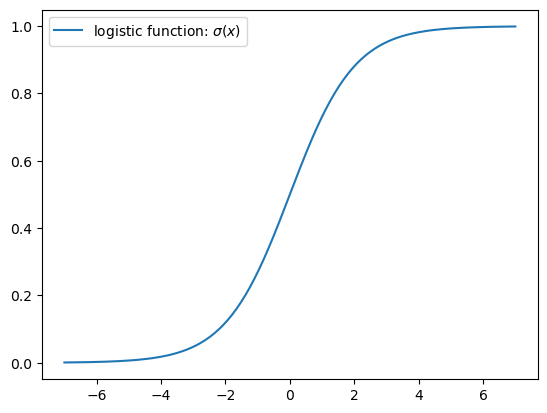

In [3]:
fig = plt.figure()
x = np.linspace(-7, 7, 200)
plt.plot(x, sigmoid(x), label=r'logistic function: $\sigma(x)$')
plt.legend()

## Use `grad` function

In [57]:
dsigmoid = grad(sigmoid)       # Obtain its gradient function

In [62]:
dsigmoid(0.0) # grad_sigmoid(1) will return an error!

0.25

In [6]:
dsigmoid(1.0) - my_dsigmoid(1.0)

2.7755575615628914e-17

## Use element-wise `egrad`

In [65]:
x_random = np.random.randn(10)
np.isclose(dsigmoid(x_random) - my_dsigmoid(x_random))

TypeError: Grad only applies to real scalar-output functions. Try jacobian, elementwise_grad or holomorphic_grad.

In [8]:
from autograd import elementwise_grad as egrad
np.isclose(egrad(sigmoid)(x_random), my_dsigmoid(x_random))

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

## Higher order gradients

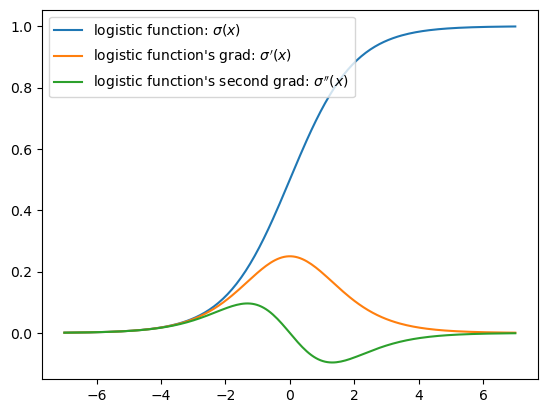

In [9]:
fig = plt.figure()
x = np.linspace(-7, 7, 200)
plt.plot(x, sigmoid(x), label=r'logistic function: $\sigma(x)$')
plt.plot(x, egrad(sigmoid)(x), label=r"logistic function's grad: $\sigma'(x)$")
plt.plot(x, egrad(egrad(sigmoid))(x), label=r"logistic function's second grad: $\sigma''(x)$")
plt.legend()

# More example

$$\large f(w_1, w_2) = \frac{1}{4} (w_1^4 + w_2^4) -\frac{1}{3} (w_1^3 +w_2^3) - w_1^2 -w_2^2 +4$$

In [10]:
def ffun(w):
    w1, w2 = w[0], w[1]
    return 1.0/4.0 * (w1**4 + w2**4) - 1.0/3.0 * (w1**3 + w2**3) - w1**2  -w2**2 +4.0

In [11]:
# ffun(np.array)
ffun(np.array([1.0, 1.0]))

1.8333333333333335

#### Take gradient with auto-diff

In [12]:
grad(ffun)(np.ones(2))

array([-2., -2.])

## Both value and grad: `value_and_grad`

In [13]:
from autograd import value_and_grad
dfdw = value_and_grad(ffun)

In [14]:
dfdw(np.ones(2))

(1.8333333333333335, array([-2., -2.]))

In [15]:
ffun(np.ones(2))

1.8333333333333335

## Gradient check with finite differences


Finite difference gradient check:

$$\large
\frac{\partial f(\mathbf{x})}{\partial x_i} \approx \frac{f(\mathbf{x}+ \epsilon \cdot \mathbf{e}_i) - f(\mathbf{x})}{\epsilon}$$

In [16]:
def finite_diff_gradient(f, initial, eps=1e-6):
    initial = np.array(initial, dtype=float)
    n = len(initial)
    output = np.zeros(n)
    for i in range(n):
        ei = np.zeros(n)
        ei[i] = 1
        f1 = f(initial + eps * ei)
        f2 = f(initial - eps * ei)
        output[i] = (f1-f2)/(2*eps)
#     output = output.reshape(n, 1)
    return output

In [17]:
w_test = np.random.randn(2)
finite_diff_gradient(ffun, w_test) # finite difference method

array([ 0.36028518, -1.03118514])

In [18]:
dfdw(w_test)[1] # auto-diff

array([ 0.36028518, -1.03118514])

## Gradient descent 

<br>

----


**Bach gradient descent algorithm:**



* random guess $\large\mathbf{w}_0$

* while **not converge**
  * $\large\mathbf{w}_t \leftarrow \mathbf{w}_{t-1} - \gamma \nabla f(\mathbf{w}_{t-1})$
-----


In [19]:
def gradient_descent(f, gamma, max_iters, w_init):
    # auto-diff the function f
    gradient = value_and_grad(f)
    w = w_init
    # gradient descent loop
    w_history = [w] # weight history container 
    f_history = [f(w)]
    
    for k in range(max_iters):
        
        # evaluate the gradient
        fw, gradw = gradient(w)
        
        
        # take gradient descent step
        w = w - gamma * gradw
        
        # record the trajectory of w and function value
        w_history.append(w)
        f_history.append(fw)
        
    return w_history, f_history

In [20]:
ws, fs = gradient_descent(ffun, 0.01, 1_000, np.array([3.5, -2.0]))

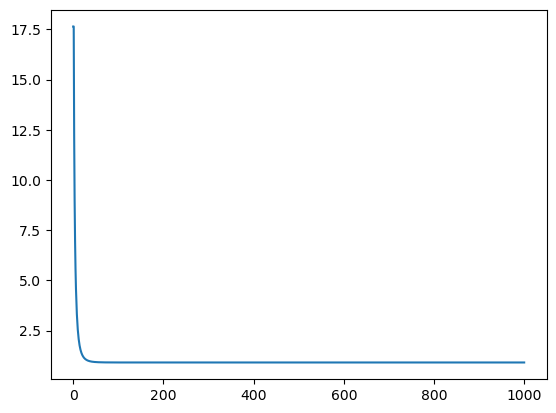

In [21]:
plt.plot(fs)

In [22]:
ws[-1] # the converged parameter at the end

array([ 2., -1.])

<div>
<img src="https://leo.host.cs.st-andrews.ac.uk/figs/CS5914/gd_gif_botright.gif" width="700"/>
</div>

## A different starting location

In [23]:
ws, fs = gradient_descent(ffun, 0.01, 1_000, np.array([-3.0, 3.0]))
ws[-1] # 

array([-1.,  2.])

<div>
<img src="https://leo.host.cs.st-andrews.ac.uk/figs/CS5914/gd_gif_topleft.gif" width="700"/>
</div>

## Matrix valued functions



$$\large f(\mathbf{W}) = \frac{1}{2} \sum_{i=1}^m\sum_{j=1}^n \mathbf{W}_{i,j}^2$$


* widely used for regularisation 

* its gradient is surprisingly simple 

$$\large \nabla f(\mathbf{W}) = \mathbf{W}$$


In [66]:
def fun_matrix(W):
    return .5 * np.sum(W**2)

In [67]:
W = np.array([[1., 2] , [3, 4]])
fun_matrix(W)

15.0

In [26]:
grad(fun_matrix)(W) # as expected 

array([[1., 2.],
       [3., 4.]])

## Multiple parameter functions


$$\large g(a, \mathbf{b}, \mathbf{C}) = (a + \mathbf{z}^\top \mathbf{b} + \mathbf{z}^\top \mathbf{C} \mathbf{z})^2$$


* the input parameters are $a$, $\mathbf{b}$, and $\mathbf{C}$
  * scalar, vector and matrix

* $\mathbf{z}$ is some fixed constant 


And we want to compute 


$$\large \frac{\partial g}{\partial a}, \frac{\partial g}{\partial \mathbf{b}}, \frac{\partial g}{\partial \mathbf{C}}$$

In [27]:
def gfun_multi(a, b, C):
    return (((a + np.dot(z.T, b) + np.dot(np.dot(z.T, C), z))) **2)

In [28]:
z = np.random.rand(3)
a, b, C = 1.0, np.array([1,2,3]), np.random.randn(3,3)
gfun_multi(a,  b, C)

55.285639980449275

## Use `grad(fun, index)`




```python
def gfun_multi(a, b, C):
    return (((a + np.dot(z.T, b) + np.dot(np.dot(z.T, C), z))) **2)
```

* `index`: 0, 1, 2, ...; the index of the input parameter

* `0`: a
* `1`: b
* ...


In [29]:
grad(gfun_multi, 0)(a, b, C) # dg/da

14.870862783369265

In [30]:
grad(gfun_multi, 1)(a, b, C) # dg/db

array([ 2, 10, 10])

In [31]:
grad(gfun_multi, 2)(a, b, C) # dg/dC

array([[0.54627988, 2.05401193, 1.93706837],
       [2.05401193, 7.72308337, 7.28337566],
       [1.93706837, 7.28337566, 6.86870236]])

## Linear regression example


Let's first simulate some dataset



$$y^{(i)} = \mathbf{w}^\top \mathbf{x}^{(i)} + b + \epsilon$$


or in matrix


$$\mathbf{y} =\mathbf{X} \mathbf{w}\, .+\, {b} + \texttt{noise}$$

In [32]:
num_features = 2
num_data = 100
true_w = np.random.rand(num_features) * 5
true_b = 2.0
# simulate the design matrix or input features
X_train = np.random.rand(num_data, num_features) * 4. - 2.
# generate the noisy observations
y_train = np.dot(X_train, true_w) + true_b + np.random.randn(num_data) 

## Loss function


$$L(\mathbf{w}) = \frac{1}{2n}\sum_{i=1}^n (y^{(i)} - h(\mathbf{x}^{(i)}; \mathbf{w}))^2$$


* where $h(\mathbf{x}^{(i)}; \mathbf{w}) = \mathbf{w}^\top\mathbf{x}^{(i)} + b$

In [33]:
def loss(w, b):
    y_pred = np.dot(X_train, w) + b
    error = y_train - y_pred
    return (0.5 / len(y_train))* np.sum(error ** 2) 

In [34]:
w_guess = np.array([1., 2.])
b_guess = 3.0
loss(w_guess, b_guess)

2.8278561075111583

## Auto-diff the gradient with `grad`


#### Two inputs: `w` and `b`: index with 0 and 1 respectively

In [37]:
grad(loss, 0)(w_guess, b_guess), grad(loss, 1)(w_guess, b_guess)

(array([ 0.70743303, -2.189569  ]), 0.8517441845071152)

## Flatten the parameters


It is more convenient to deal with one vector rather than multiple parameters


* solution: flatten all the parameters into one big vector

In [38]:
from autograd.misc.flatten import flatten_func

In [39]:
params = [w_guess, b_guess]

In [44]:
def loss_with_params(params):
    w = params[0]
    b = params[1]
    return loss(w, b)

In [45]:
loss_flat, unflatten_fun, ps = flatten_func(loss_with_params, params)

In [46]:
ps

array([1., 2., 3.])

In [47]:
loss_flat(ps)[0], loss_with_params(params), loss(w_guess, b_guess)

(2.8278561075111583, 2.8278561075111583, 2.8278561075111583)

In [48]:
unflatten_fun(ps)

[array([1., 2.]), array(3.)]

## Linear regression learning with gradient descent 

In [49]:
weights, losses = gradient_descent(loss_flat, 0.01, 2_000, np.zeros(3))

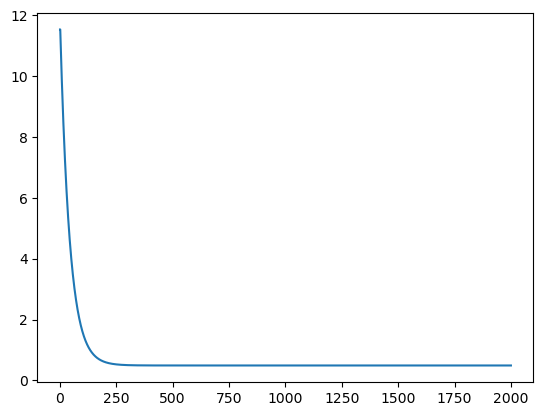

In [50]:
plt.plot(losses)

## Check the solution

In [51]:
true_w, true_b

(array([0.8013393, 3.7280506]), 2.0)

In [52]:
weights[-1]

array([0.74472655, 3.72220639, 2.15297618])

In [53]:
X_train_dummy = np.column_stack((X_train, np.ones(X_train.shape[0])))

In [55]:
np.linalg.lstsq(X_train_dummy, y_train)[0]

array([0.74472655, 3.72220639, 2.15297619])